# Keras Baseline Engine for VAS Challenge 2019

## Imports

In [1]:
%conda update conda
%conda update --all

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.5.15  |                0         133 KB
    conda-4.6.14               |           py36_0         2.1 MB
    openssl-1.1.1c             |       h7b6447c_1         3.8 MB
    ------------------------------------------------------------
                                           Total:         6.0 MB

The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2019.3.9~ --> pkgs/main::ca-certificates-2019.5.15-0
  openssl            conda-forge::openssl-1.1.1b-h14c3975_1 --> pkgs/main::openssl-1.1.1c-h7b6447c_1

The following packages will be SUPERSEDED by a higher-priority channel:

  conda                                         conda-forge --> pkgs/main



ca-certifica

In [1]:
import os
import sys
import glob
import tqdm
import keras
import random
import librosa
import numpy as np
import pandas as pd
import librosa.display
import tensorflow as tf
from matplotlib import patches
from matplotlib import pyplot as plt

# Local file import
import DftSpectrogram
import Metrics

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
tf.logging.set_verbosity(tf.logging.ERROR)

print("Done!")

Using TensorFlow backend.


Done!


## Path to train dataset dir

In [2]:
dataset_dir = "../../../data/files"
train_dataset_dir = os.path.join(dataset_dir, "Training_Data/")

!tree {train_dataset_dir} -L 1

/bin/sh: 1: tree: not found


## File paths

In [3]:
wav_paths = sorted(glob.glob(os.path.join(train_dataset_dir, '**/*.wav'), recursive=True))
random.shuffle(wav_paths)

train_paths = wav_paths[:40000]
dev_paths = wav_paths[40000:]

train_human  = sorted(filter(lambda path: "human" in path, train_paths))
train_spoof = sorted(filter(lambda path: "spoof" in path, train_paths))
dev_human  = sorted(filter(lambda path: "human" in path, dev_paths))
dev_spoof = sorted(filter(lambda path: "spoof" in path, dev_paths))

print("Train Human: %d" % len(train_human))
print("Train Spoof: %d" % len(train_spoof))
print("Dev   Human: %d" % len(dev_human))
print("Dev   Spoof: %d" % len(dev_spoof))

Train Human: 8225
Train Spoof: 31775
Dev   Human: 2097
Dev   Spoof: 7903


## Raw Feature Extractor 

(66000,)


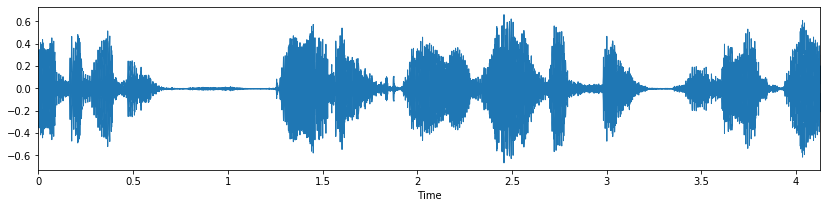

In [4]:
def get_feature(wav_path, length=66000, random_start=False):
    try:
        x, sr = librosa.load(wav_path, sr=None)
        assert sr == 16000
        if length > len(x):
            x = np.concatenate([x] * int(np.ceil(length/len(x))))
        if random_start:
            x = x[random.randint(0, len(x) - length):]
        feature = x[:length]
        return feature / np.max(np.abs(feature))
    except Exception as e:
        print("Error with getting feature from %s: %s" % (wav_path, str(e)))
        return None

feature = get_feature(random.choice(train_human), length=66000, random_start=True)
plt.figure(figsize=(14, 3))
librosa.display.waveplot(feature, sr=16000)
print(feature.shape)

## Train Data Generator

2500
(16, 66000, 1)
(16, 2)


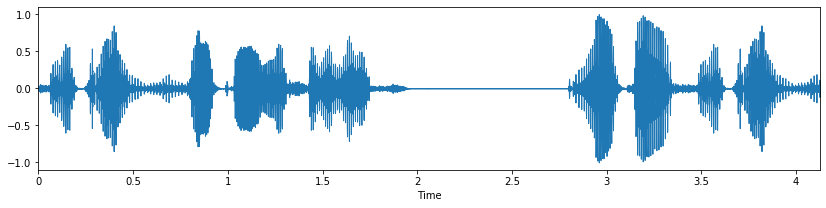

In [5]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, human_paths, spoof_paths, feature_extractor, batch_size=16):
        self.human_paths = human_paths
        self.spoof_paths = spoof_paths
        self.batch_size = batch_size
        self.feature_extractor = feature_extractor
        self.n_samples = len(self.human_paths) + len(self.spoof_paths)
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(self.n_samples / self.batch_size))
    
    def __getitem__(self, index):
        return self.data_generation()
        
    def on_epoch_end(self):
        random.shuffle(self.human_paths)
        random.shuffle(self.spoof_paths)
        
    def data_generation(self):
        wavs, labels = [], []
        while len(wavs) < self.batch_size // 2:
            wav = self.feature_extractor(random.choice(self.human_paths))
            if wav is not None:
                wavs.append(wav)
                labels.append(0)
        while len(wavs) < self.batch_size:
            wav = self.feature_extractor(random.choice(self.spoof_paths))
            if wav is not None:
                wavs.append(wav)
                labels.append(1)
        return np.stack(wavs, 0)[..., np.newaxis], keras.utils.to_categorical(np.stack(labels, 0), num_classes=2)

train_get_feature = lambda path: get_feature(path, length=66000, random_start=True)
train_data_generator = DataGenerator(train_human, train_spoof, train_get_feature, batch_size=16)
features, labels = train_data_generator[0]
plt.figure(figsize=(14, 3))
librosa.display.waveplot(features[0, ..., 0], sr=16000)
print(len(train_data_generator))
print(features.shape)
print(labels.shape)

## Dev Data Generator

10000
(1, 66000, 1)
(1, 2)


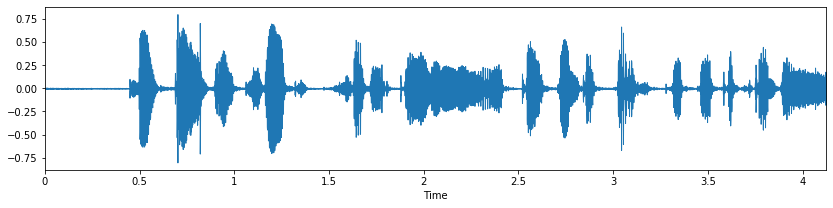

In [6]:
class DevDataGenerator(keras.utils.Sequence):
    def __init__(self, human_paths, spoof_paths, feature_extractor):
        self.human_paths = human_paths
        self.spoof_paths = spoof_paths
        self.paths = human_paths + spoof_paths
        self.labels = [0] * len(human_paths) + [1] * len(spoof_paths)
        self.feature_extractor = feature_extractor
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        feature = self.feature_extractor(self.paths[index])[np.newaxis, ..., np.newaxis]
        return feature, keras.utils.to_categorical([self.labels[index]], num_classes=2)
        
dev_get_feature = lambda path: get_feature(path, length=66000, random_start=False)
dev_data_generator = DevDataGenerator(dev_human, dev_spoof, dev_get_feature)
features, labels = dev_data_generator[0]
plt.figure(figsize=(14, 3))
librosa.display.waveplot(features[0, ..., 0], sr=16000)
print(len(dev_data_generator))
print(features.shape)
print(labels.shape)

## Feature Extractor Layer

spectrogram shape: [256, None, 1]
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
dft_spectrogram_1 (DftSpectr (None, 256, None, 1)      0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
(1, 256, 256, 1)


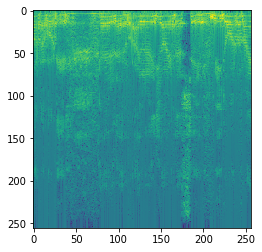

In [7]:
dft_conf = {"length": 512,
            "shift": 256,
            "nfft": 512,
            "mode": 'log',
            "normalize_feature": True}

inputs = keras.layers.Input(shape=(None, 1))
outputs = DftSpectrogram.DftSpectrogram(**dft_conf)(inputs)
model = keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

result = model.predict(feature[np.newaxis, ..., np.newaxis])
print(result.shape)
imgplot = plt.imshow(result[0, :, : ,0])

## Build Model

In [8]:
mobile_net_v2 = keras.applications.MobileNetV2(input_shape=result[0].shape, weights=None, classes=2)

inputs = keras.layers.Input(shape=(None, 1))
outputs = DftSpectrogram.DftSpectrogram(**dft_conf)(inputs)

model = keras.models.Model(inputs=inputs, outputs=mobile_net_v2(outputs))
model.summary()

spectrogram shape: [256, None, 1]
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
dft_spectrogram_2 (DftSpectr (None, 256, None, 1)      0         
_________________________________________________________________
mobilenetv2_1.00_256 (Model) (None, 2)                 2259970   
Total params: 2,259,970
Trainable params: 2,225,858
Non-trainable params: 34,112
_________________________________________________________________


## Callbacks

In [9]:
def exp_decay(epoch, k=0.1, initial_rate=0.0001):
    return initial_rate * np.exp(-k * epoch)

class Saver(keras.callbacks.Callback):
    def __init__(self, temp_models_dir):
        super().__init__()
        self.temp_models_dir = temp_models_dir
    def on_train_begin(self, logs={}):
        !mkdir -p {self.temp_models_dir}
        !rm {self.temp_models_dir}/*
    def on_epoch_end(self, epoch, logs={}):
        model.save("%s/model_epoch_%d.h5" % (self.temp_models_dir, epoch + 1))
        
class Eer(keras.callbacks.Callback):
    def __init__(self, dev_data_generator):
        super().__init__()
        self.dev_data_generator = dev_data_generator
        self.val_eers = None
    def on_train_begin(self, logs={}):
        self.val_eers = []
    def on_epoch_end(self, epoch, logs):
        results = model.predict_generator(self.dev_data_generator, verbose=1)
        human = results[:len(self.dev_data_generator.human_paths), 0]
        spoof = results[len(self.dev_data_generator.human_paths):, 0]
        val_eer = Metrics.compute_err(human, spoof)[0]
        self.val_eers.append(val_eer)
        logs["val_eer"] = val_eer
        print("%sEER = %0.3f%%" % (" "*20, val_eer))

learning_rate   = keras.callbacks.LearningRateScheduler(exp_decay)
saver           = Saver("./temp_models/")
eer             = Eer(dev_data_generator)
        
callbacks     = [learning_rate, saver, eer]
print("Total %d callbacks" % len(callbacks))

Total 3 callbacks


## Train Model

In [10]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(lr=1e-4, decay=0), metrics=['accuracy'])

model.fit_generator(train_data_generator,
                    steps_per_epoch = None,
                    epochs = 50,
                    callbacks = callbacks,
                    use_multiprocessing = True,
                    workers = 12,
                    )

rm: cannot remove './temp_models//*': No such file or directory
Epoch 1/50
 1497/10000 [===>..........................] - ETA: 1:07

Process ForkPoolWorker-20:
Process ForkPoolWorker-17:
Process ForkPoolWorker-13:
Process ForkPoolWorker-14:
Process ForkPoolWorker-18:
Process ForkPoolWorker-19:
Process ForkPoolWorker-23:
Process ForkPoolWorker-16:
Process ForkPoolWorker-21:
Process ForkPoolWorker-15:
Process ForkPoolWorker-22:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/co

KeyboardInterrupt: 

## Load best checkpoint

In [17]:
model.predict(feature.reshape(1, -1, 1))

array([[0.02356073, 0.97643924]], dtype=float32)

In [15]:
best_checkpoint = np.argmin(eer.val_eers)
print("Best checkpoint - Epoch %d: EER = %0.3f%%" % (best_checkpoint + 1, eer.val_eers[best_checkpoint]))

model.load_weights("./temp_models/model_epoch_%d.h5" % (best_checkpoint + 1))
print("Done!")

Best checkpoint - Epoch 46: EER = 0.735%
Done!


## Save model

In [16]:
model.save("./models/baseline_model.h5")
print("Done!")

Done!


## Check single files

In [17]:
print(model.predict(dev_get_feature(random.choice(dev_human))[np.newaxis, ..., np.newaxis])[0][0])
print(model.predict(dev_get_feature(random.choice(dev_spoof))[np.newaxis, ..., np.newaxis])[0][0])

0.9999999
3.4658676e-09


## Run dev generator

In [18]:
results = model.predict_generator(dev_data_generator, verbose=1, steps=None)
print(len(results))
print(results[:5])

10000/10000 [==============================] - 41s 4ms/step
10000
[[9.9996829e-01 3.1705771e-05]
 [1.0000000e+00 2.7587401e-08]
 [9.9997389e-01 2.6144800e-05]
 [9.9999964e-01 4.1709922e-07]
 [9.9998868e-01 1.1340149e-05]]


## Metrics

2021
7979

EER = 0.735 %   @  0.939


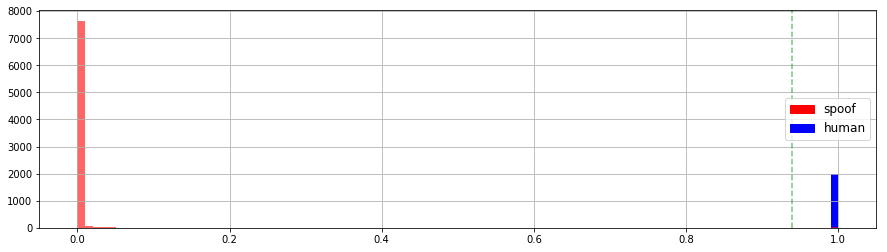

In [22]:
human = results[:len(dev_data_generator.human_paths), 0]
spoof = results[len(dev_data_generator.human_paths):, 0]

print(len(human))
print(len(spoof))

eer, threshold = Metrics.compute_err(human, spoof)

print("\nEER = %0.3f %%   @  %0.3f" % (eer, threshold))

plt.figure(figsize=(15, 4))
plt.hist(human, 99, facecolor='b', alpha=1)
plt.hist(spoof, 99, facecolor='r', alpha=0.6)
red_patch = patches.Patch(color='red', label='spoof')
blue_patch = patches.Patch(color='blue', label='human')
plt.axvline(x=threshold, linestyle='--', color='g', alpha=0.5)
plt.legend(handles=[red_patch, blue_patch], loc=5, fontsize=12)
plt.grid(True)
plt.show()

# Keras Baseline Engine for VAS Challenge 2019